#Table of Contents
* [1. Fitting a local equilibrium model to foam scan data](#1.-Fitting-a-local-equilibrium-model-to-foam-scan-data)
	* [1.1 Load data](#1.1-Load-data)
	* [1.2 Experimental data](#1.2-Experimental-data)
	* [1.3 Assign values to the physical parameters](#1.3-Assign-values-to-the-physical-parameters)
	* [1.4 Fit a new liquid relperm](#1.4-Fit-a-new-liquid-relperm)
	* [1.5 Relative permeability curves](#1.5-Relative-permeability-curves)
	* [1.6 Visualize RelPerms](#1.6-Visualize-RelPerms)
	* [1.7 Define the foam model](#1.7-Define-the-foam-model)
* [2. Boeije-Rossen method](#2.-Boeije-Rossen-method)
	* [2.1 Compare the model vs measured saturations](#2.1-Compare-the-model-vs-measured-saturations)
* [3. Ma et al. model](#3.-Ma-et-al.-model)
* [4. Nonlinear least-square model](#4.-Nonlinear-least-square-model)
	* [4.1 Calculate the liquid saturation for data points](#4.1-Calculate-the-liquid-saturation-for-data-points)
	* [4.2 Calculate the experimental foam parameters](#4.2-Calculate-the-experimental-foam-parameters)
	* [4.3 Create and solve a JuMP model: three parameters](#4.3-Create-and-solve-a-JuMP-model:-three-parameters)
	* [4.4 Create and solve a JuMP model: five parameters](#4.4-Create-and-solve-a-JuMP-model:-five-parameters)
	* [4.5 Visualize the results](#4.5-Visualize-the-results)
* [5. A discontinuous model](#5.-A-discontinuous-model)


# 1. Fitting a local equilibrium model to foam scan data

This notebook explains how mathematical programming can be used to optimize the parameters of an implicit function. Here, I will use `Julia` language and the package `JuMP`.

In [19]:
using JuMP, Roots, PyPlot, Ipopt, DataFrames, NLopt, PyCall, Optim, JLD
@pyimport scipy.optimize as so
PyPlot.rc("font", family="sans")

## 1.1 Load data

First, I read the data table using the `DataFrames` package.

In [20]:
data1 = readtable("AOS0.1_N2_Benth_CT_mu_foam.csv")

,ug,uw,mu_gas,mu_liq,muf_tot,sw_ave,muf_in,fg_in,fg_out,muf_err,dp_tot,dp_mid,dp_err
1,9.597761171093203e-6,4.408724185371063e-6,1.985669609932038e-5,0.0009522473417671935,1.3703433884049447,0.21535058320872366,1.1992281930360988,0.6717795973638833,0.6717795973638833,0.062343301356885004,13.43641637588488,5.533462108042242,0.6112851438305615
2,1.2664655630142102e-5,1.469574728457021e-6,1.977635989632639e-5,0.0009523006689676796,0.896266768150563,NaN,0.8048576616669633,0.8920082484966881,0.8920082484966881,0.01643816774500891,8.868176584905664,3.7476341396226407,0.16264864376914023
3,7.001986063664326e-6,7.347873642285104e-6,1.9790638657526046e-5,0.0009522911223956077,1.0230186268305255,0.22406616252352063,0.9239163392999863,0.4757842395952498,0.4757842395952498,0.03060883265555942,10.276756577881102,4.367634034872134,0.30748171546869835
4,1.2692150050892958e-5,1.4695747284570201e-6,1.976998952990015e-5,0.000952304937807275,0.9000584730052837,0.20267681041750552,0.7556004190237138,0.8921826348034672,0.8921826348034672,0.012117141447633178,8.923017564551422,3.5251230306345724,0.12012715752607571
5,8.335663112177594e-6,5.878298913828084e-6,1.9814418470822597e-5,0.0009522752897024945,1.2144808499359832,0.22657863606547501,1.08519984425544,0.5726673991849213,0.5726673991849213,0.023028734285863498,12.084555908212565,5.081486925120773,0.22914484570716626
6,1.1025843167576564e-5,2.9391494569140423e-6,1.98385261092837e-5,0.0009522593220125901,1.446497587580578,0.20846654522269922,1.2523231420952228,0.7784888741991155,0.7784888741991155,0.015284941917272575,14.141103391393438,5.761334032786885,0.14942710298267567
7,1.3855965540155767e-5,7.347873642285109e-7,1.9673777411930132e-5,0.0009523701572906635,0.29959423577625455,0.20844761979539012,0.17969054703612272,0.9488956149431277,0.9488956149431277,0.01189036670638733,3.0601028910441603,0.863711838629798,0.12145008544478474
8,1.0332037849371654e-5,3.6739368211425524e-6,1.983990555101873e-5,0.0009522584108493258,1.4651793200471315,0.21572775844057535,1.2435177983848489,0.7246767451888602,0.7246767451888602,0.036170153736337265,14.365772684035845,5.737613386325921,0.3546406910153061
9,1.1880106785033464e-5,2.204362092685532e-6,1.979644826774842e-5,0.0009522872467367586,1.1594328345662885,0.20542147766277513,0.9711606535359787,0.8362390728114996,0.8362390728114996,0.021733289851570817,11.431703266818703,4.50606541391106,0.21428453049447882
10,1.4442826748796491e-6,1.3226172556113189e-5,1.9701304901755787e-5,0.0009523513517496234,0.5468685358536386,0.2313416826007245,0.4776860747031596,0.09600149796885661,0.09600149796885661,0.04902451694287516,5.6163142583518955,2.3086181748329624,0.5034794936324034


## 1.2 Experimental data

In [21]:
# Viscosity data [Pa.s]
muw = float(data1[:mu_liq])
mug = float(data1[:mu_gas])
# Foam quality
ug = float(data1[:ug]) # [m/s]
uw = float(data1[:uw]) # [m/s]
u = ug+uw # [m/s]
fg_exp = ug./u # [-]
# Foam apparent viscosity [Pa.s]
muf_exp = float(data1[:muf_tot]) # [Pa.s]
sw_ct= float(data1[:sw_ave])
n_data = length(ug)
# filter the low quality data for the low quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_low= find(fg_exp.<=fg_trans)
fg_low= fg_exp[ind_fg_low]
sw_low= sw_ct[ind_fg_low]
muf_low= muf_exp[ind_fg_low]
muw_low= muw[ind_fg_low]
# filter the high quality data for the high quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_high= find(fg_exp.>=fg_trans)
fg_high= fg_exp[ind_fg_high]
sw_high= sw_ct[ind_fg_high]
muf_high= muf_exp[ind_fg_high]
println("Data is loaded.")

Data is loaded.


In [22]:
u

17-element Array{Float64,1}:
 1.40065e-5
 1.41342e-5
 1.43499e-5
 1.41617e-5
 1.4214e-5 
 1.3965e-5 
 1.45908e-5
 1.4006e-5 
 1.40845e-5
 1.46705e-5
 1.45016e-5
 1.41953e-5
 1.46302e-5
 1.47197e-5
 1.45658e-5
 1.46839e-5
 1.78987e-5

## 1.3 Assign values to the physical parameters

In [23]:
# IFT value [N/m]
sigma_wg = 0.03;

## 1.4 Fit a new liquid relperm

Here, I fit a new liquid relperm to the low quality data points.

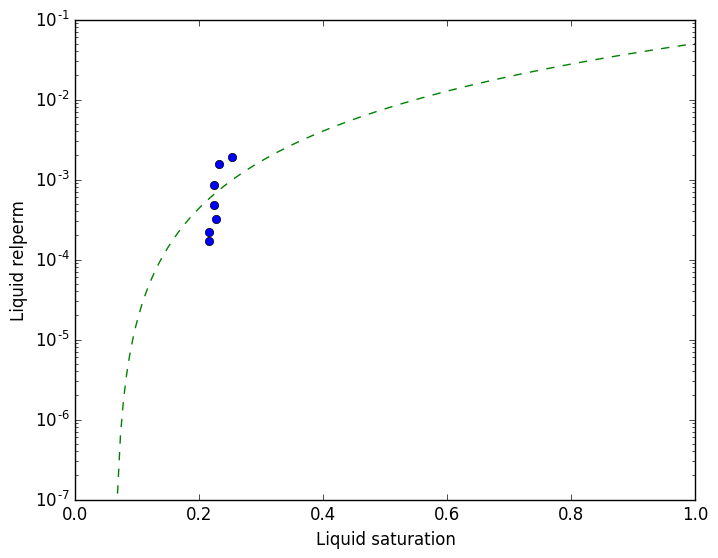

4-element Array{Float64,1}:
 0.05 
 2.46 
 0.063
 0.001

In [24]:
# I only use the less-scattered data in the low quality region
#filter for measured saturation
ind1= ~isnan(sw_low)
krw_exp= (1.0-fg_low[ind1]).*muw_low[ind1]./muf_low[ind1]
sw_low_ct=sw_low[ind1]
n_low=length(sw_low_ct)
semilogy(sw_low_ct, krw_exp, "o")
m1 = Model(solver=IpoptSolver(print_level=1))
#m = Model()
# define the variables of the foam model
#@variable(m1, 0.05<=nw_fit<=6.0)
@variable(m1, nw_fit==2.460)
@variable(m1, 0.05<=krw0_fit<=1.0)
#@variable(m1, 0.001<=swc_fit<=0.3)
@variable(m1, swc_fit==0.063)
@variable(m1, 0.001<=sgr_fit<=0.1)
@setNLObjective(m1, Min, sum{(log(krw_exp[i])-log(krw0_fit)-nw_fit*log((sw_low_ct[i]-swc_fit)/(1.0-swc_fit-sgr_fit)))^2, i=1:n_low})
#@setNLObjective(m1, Min, sum{(krw_exp[i]-krw0_fit*((sw_low_ct[i]-swc_fit)/(1.0-swc_fit-sgr_fit))^nw_fit)^2, i=1:n_low})
solve(m1)
# get the result
liq_relperm=[getValue(krw0_fit), getValue(nw_fit), getValue(swc_fit), getValue(sgr_fit)]
sw1=[linspace(liq_relperm[3], 0.3, 50); linspace(0.3,1.0-liq_relperm[4], 50)]
semilogy(sw1, liq_relperm[1]*((sw1-liq_relperm[3])/(1-liq_relperm[4]-liq_relperm[3])).^liq_relperm[2], "--")
xlabel("Liquid saturation")
ylabel("Liquid relperm")
#df_krw=DataFrame(sw=sw_low_ct, krw=krw_exp)
#writetable("krw_mid_AOS.csv", df_krw)
liq_relperm

## 1.5 Relative permeability curves

In [25]:
# Relperm data
# swc = 0.184 # original
swc=0.05 # the new fit with the lowest swc measured in the CT experiments
sgr = 0.03
krg0 = 0.587
ng = 0.938
krw0 = 0.720456
nw = 4.42378   
sws(sw::Real)=((sw>swc)*(sw<1-sgr)*(sw-swc)/(1-sgr-swc)+(sw>=1-sgr)*1.0)
sws(sw::Array{Float64})=((sw.>swc).*(sw.<1-sgr).*(sw-swc)/(1-sgr-swc)+
(sw.>=1-sgr).*ones(size(sw)))
kr(sw)=((sw.>=swc).*krg0.*(1-sws(sw)).^ng+(sw.<swc).*(1+(krg0-1)/swc*sw))
krw(sw)=((sw.<=1-sgr).*krw0.*sws(sw).^nw+(sw.>1-sgr).*
(-(1-krw0)/sgr.*(1.0-sw)+1.0))

krw (generic function with 1 method)

In [26]:
mean(mug)

1.9767015048344527e-5

## 1.6 Visualize RelPerms

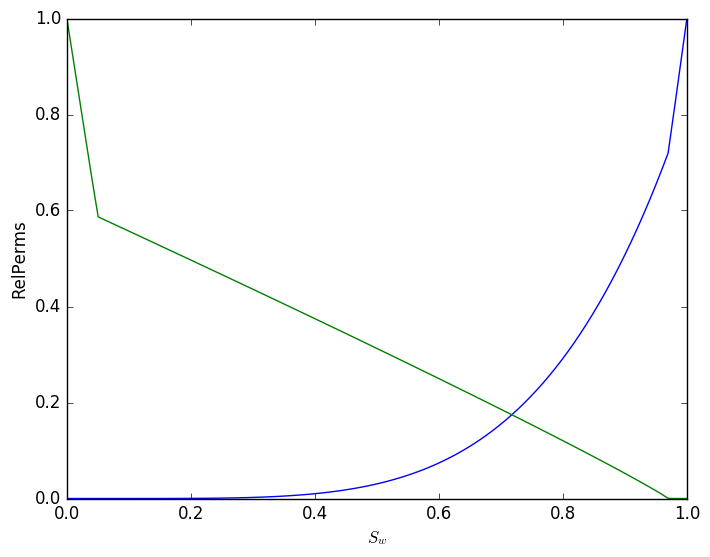

PyObject <matplotlib.text.Text object at 0x7f6eb7e04390>

In [27]:
sw_plot = collect(linspace(0.0,1.0, 100))
plot(sw_plot, krw(sw_plot), sw_plot, kr(sw_plot))
xlabel(L"S_w")
ylabel("RelPerms")

## 1.7 Define the foam model

In [28]:
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2)=(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u)=(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 1 method)

## 4.1 Calculate the liquid saturation for data points

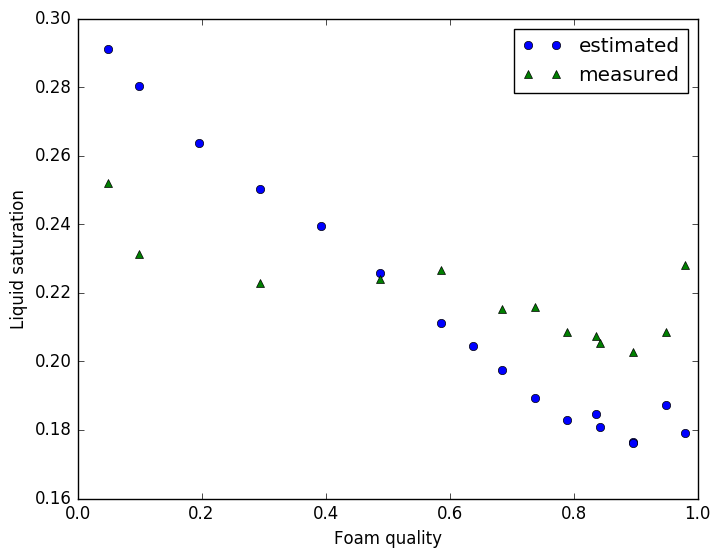

In [29]:
sw_exp = (1-swc-sgr)*(muw.*(1-fg_exp)./(krw0*muf_exp)).^(1/nw)+swc
labdaw = krw(sw_exp)./muw
labdag = kr(sw_exp)./mug
plot(fg_exp, sw_exp, "o")
plot(fg_exp, sw_ct, "^")
xlabel("Foam quality")
ylabel("Liquid saturation")
legend(["estimated", "measured"]);

# 2. Boeije-Rossen method

I'm trying to automate the Boeije-Rossen method, using linear regression for the high quality and power-law for the low quality region.

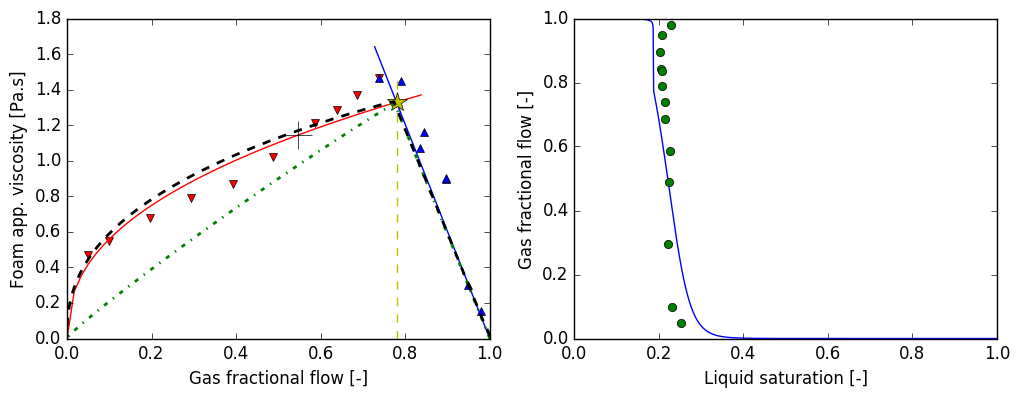

5-element Array{Float64,1}:
      8.17335e5 
 100000.0       
      0.186986  
      7.65552e-5
      1.37079   

In [30]:
# fit a line to the high quality data; note: y=a+b*x
w1=ones(length(fg_high)+1) # weight factor
a_high=zeros(2)
a_high[1], a_high[2]=linreg([fg_high;1.0], [muf_high;0.0])
a_high[1]=-a_high[2] # force it to go through point [1,0]
# fit a power law to the low quality data
# y=a*x^b; log(y)=log(a)+b*log(x)
w2=ones(length(fg_low)) # weight factor
w2[end-3:end]=5.0 # a larger weight to the points near the transition
a_low=zeros(2)
a_low[1], a_low[2]=linreg(log(fg_low),log(muf_low))
fg_low_range=collect(linspace(0.0, maximum(fg_low)+0.1, 50))
fg_high_range=collect(linspace(maximum(fg_low)-0.01,1.0, 10))
figure(figsize=[12,4])
subplot(1,2,1)
plot(fg_low, muf_low, "vr", fg_low_range, exp(a_low[1])*fg_low_range.^a_low[2], "r-")
plot(fg_high, muf_high, "b^", fg_high_range, a_high[1]+a_high[2]*fg_high_range, "b-")
# find the transition quality
fun1(x)=exp(a_low[1])*x^a_low[2]-(a_high[1]+a_high[2]*x)
fg_trans = fzero(fun1, maximum(fg_low))
muf_trans = a_high[1]+a_high[2]*fg_trans
plot(fg_trans, muf_trans, "*y", markersize=15, [fg_trans, fg_trans], [0.0, 1.1*muf_trans], "--y", linewidth=1)
xlabel("Gas fractional flow [-]")
ylabel("Foam app. viscosity [Pa.s]")
# find the transition saturation (or fmdry)
sw_trans = (1-swc-sgr)*(muw[ind_mu_max].*(1-fg_trans)./(krw0*muf_trans)).^(1/nw)+swc
fmdry_br= sw_trans # physically it should be minimum(sw_ct)
# find fmmob
FM_trans = mug[ind_mu_max]/muw[ind_mu_max]*fg_trans/(1-fg_trans)*(krw(sw_trans)/kr(sw_trans))
fmmob_br= 1.0/FM_trans-1.0
# find epdry
epdry_br= 100000.0 # very convenient
# visualize the three-parameter fit
x_br=[fmmob_br, epdry_br, fmdry_br]
sw_val = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
fg_opt = fg(sw_val, x_br)
muf_opt = mu_foam(sw_val, x_br)
plot(fg_opt, muf_opt, "-.g", linewidth=2)
# calculate the epcap
dryout(x, sw)=0.5+atan(x[1]*(sw-x[2]))/π
fg_plus=0.7*fg_trans
muf_plus= exp(a_low[1])*fg_plus^a_low[2]
plot(fg_plus, muf_plus, "k+", markersize=20)
sw_plus=(1-swc-sgr)*(muw[ind_mu_max].*(1-fg_plus)./(krw0*muf_plus)).^(1/nw)+swc
#FM_plus = mug[ind_mu_max]/muw[ind_mu_max]*fg_plus/(1-fg_plus)*(krw(sw_plus)/kr(sw_plus))
#epcap_br=log((1.0/FM_trans-1.0)/(1.0/FM_plus-1.0)*
#dryout([epdry_br,fmdry_br],sw_plus)/dryout([epdry_br,fmdry_br],sw_trans))/log(muf_plus/muf_trans)
epcap_br=log((kr(sw_trans)*muf_plus-fg_plus*mug[ind_mu_max])/
(fmmob_br*mug[ind_mu_max]*fg_plus))/log(muf_trans/muf_plus)
# calculate fmcap
ind_muf_min = indmin(muf_exp)
fmcap_br= muf_exp[ind_muf_min]*u[ind_muf_min]/sigma_wg
# correct for fmmob
fmmob_br_new = fmmob_br*(muf_trans/muf_exp[ind_muf_min])^epcap_br
# visualize the final results
x_br2= [fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]
sw_p = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n1 = length(sw_p)
muf_opt = zeros(n1)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n1
    fmu(x)= x-mu_foam2(sw_p[i], x_br2[1:3], x_br2[4:5], x, u_ave)
    muf_opt[i]=fzero(fmu, 0.9)
end
plot(fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), mu_foam2(sw_p, x_br2[1:3], 
x_br2[4:5], muf_opt, u_ave), "k--", linewidth=2)
subplot(1,2,2)
plot(sw_p, fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), sw_ct, fg_exp, "o")
xlabel("Liquid saturation [-]")
ylabel("Gas fractional flow [-]")
fit_br=[fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]

# 3. Ma et al. model

The optimization procedure of Ma et al. can be impplemented as follows:

# 4. Nonlinear least-square model

## 4.2 Calculate the experimental foam parameters

See our paper for more details.

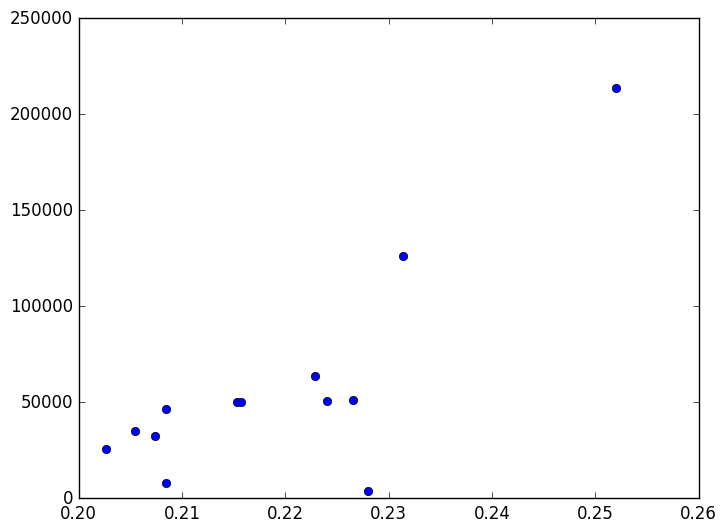

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6eb7ed9a90>

In [31]:
#FM = mug./muw.*fg_exp./(1-fg_exp).*(krw(sw_exp)./kr(sw_exp))
FM = mug.*fg_exp./(kr(sw_exp).*muf_exp)
f_foam = 1.0./FM-1.0;
plot(sw_ct, 1./FM-1, "o")

## 4.3 Create and solve a JuMP model: three parameters

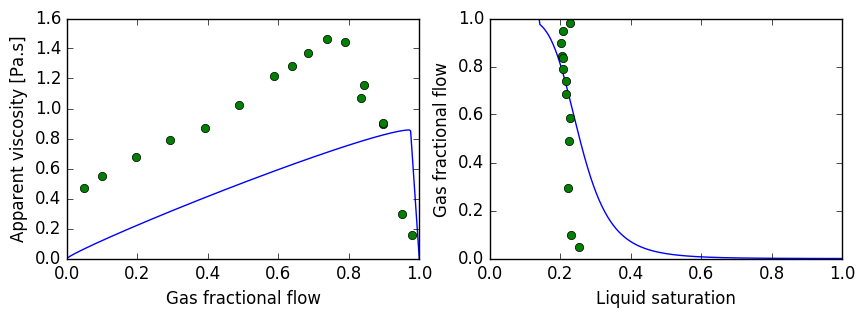

3-element Array{Float64,1}:
 23573.2     
 46976.9     
     0.141683

In [32]:
# m1 = Model(solver=IpoptSolver(print_level=1))
m1 = Model(solver=NLoptSolver(algorithm=:LN_COBYLA))
#m = Model()
# define the variables of the foam model
@variable(m1, 10<=fmmob<=5000000)
@variable(m1, 10<=epdry<=100000, start=50000)
@variable(m1, swc<=fmdry<=swc+0.4)
# @variable(m1, fmdry==minimum(sw_ct))
w=ones(length(muf_exp))
ind_mu_max= indmax(muf_exp)
w[ind_mu_max-3:ind_mu_max+1]=100
@setNLObjective(m1, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)))^2, i=1:n_data})
# @setNLObjective(m1, Min, sum{w[i]*(tan(f_foam[i]/fmmob-0.5)-(epdry*(sw_exp[i]-fmdry))/pi)^2, i=1:n_data})
solve(m1)
# get the result
x1 = [getValue(fmmob), getValue(epdry), getValue(fmdry)]
sw_val = collect(linspace(0,1.0, 500))
fg_opt = fg(sw_val, x1)
muf_opt = mu_foam(sw_val, x1)
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg_opt, muf_opt, fg_exp, muf_exp, "o")
xlabel("Gas fractional flow")
ylabel("Apparent viscosity [Pa.s]")
subplot(1,2,2)
plot(sw_val, fg_opt, sw_ct, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")
x1

## 4.4 Create and solve a JuMP model: five parameters

Here's a list of NLopt algorithms (note: "NLOPT_{G,L}{N,D}_xxxx, where G/L denotes global/local optimization and N/D denotes derivative-free/gradient-based algorithms, respectively"  
  - GN_DIRECT_L
  - GN_DIRECT
  - GN_DIRECT_L_RAND
  - GN_DIRECT_NOSCAL
  - GN_DIRECT_L_NOSCAL
  - GN_DIRECT_L_RAND_NOSCAL
  - GN_ORIG_DIRECT_L
  - GN_CRS2_LM
  - G_MLSL_LDS
  - GN_MLSL
  - GD_STOGO
  - GD_STOGO_RAND
  - GN_ISRES
  - GN_ESCH
  - LN_COBYLA
  - LN_BOBYQA
  - LN_NEWUOA_BOUND
  - LN_NEWUOA
  - LN_PRAXIS
  - LN_NELDERMEAD
  - LN_SBPLX
  - LD_MMA
  - LD_CCSAQ
  - LD_SLSQP
  - LD_LBFGS
  - LD_TNEWTON_PRECOND
  - LD_TNEWTON_PRECOND_RESTART
  - LD_TNEWTON
  - LD_TNEWTON_RESTART
  - LD_VAR2
  - LD_VAR1

In [33]:
#m2 = Model(solver=IpoptSolver(print_level=1))
m2 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@variable(m2, 10<=fmmob<=10000000, start=x1[1])
#@variable(m2, epdry==10000)
@variable(m2, 10<=epdry<=100000, start=x1[2])
#@variable(m2, swc<=fmdry<=sw_exp[ind_mu_max])
@variable(m2, fmdry==minimum(sw_ct))
@variable(m2, 1e-7<=fmcap<=1e-4, start=fmcap_br)
#@variable(m2, fmcap==7.65552e-5)
@variable(m2, -0.0<=epcap<=4.0)
w[ind_mu_max-1:ind_mu_max+3]=100
#@setNLObjective(m2, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(1.0-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)/f_foam[i]
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, :Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))^2, i=1:n_data})
@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})

# solve it
solve(m2)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
    9.01243e6 
 1929.4       
    0.202677  
    9.50675e-5
    0.345713  

In [34]:
m2 = Model(solver=IpoptSolver(print_level=1))
#m2 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@variable(m2, 10<=fmmob<=100000000)
@variable(m2, 10<=epdry<=100000, start=80000)
#@variable(m2, swc<=fmdry<=sw_exp[ind_mu_max])
@variable(m2, fmdry==minimum(sw_ct))
@variable(m2, 1e-7<=fmcap<=1e-3)
@variable(m2, -0.0<=epcap<=4.0)
w=ones(length(muf_exp))
w[ind_mu_max-1:ind_mu_max+2]=2
w[3:4]=10000
#@setNLObjective(m2, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(1.0-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)/f_foam[i]
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, :Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*
#    (fmcap/(u[i]*(1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*
#    (fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))/sigma_wg))^epcap)))^2, i=1:n_data})
@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(1.0-(1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))/muf_exp[i])^2, i=1:n_data})

# solve it
solve(m2)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
     5.3498e7   
 24741.6        
     0.202677   
     0.000497894
     1.22201e-5 

In [35]:
fit_br
minimum(sw_exp)
JuMP.getobjectivevalue(m2)
fit_br

5-element Array{Float64,1}:
      8.17335e5 
 100000.0       
      0.186986  
      7.65552e-5
      1.37079   

## 4.5 Visualize the results

One method is to calculate the pressure drop in different gas and liquid rates, and plot the pressure drop contours versus gas and liquid velocity. The following result is visualized for a few average total flow rates.

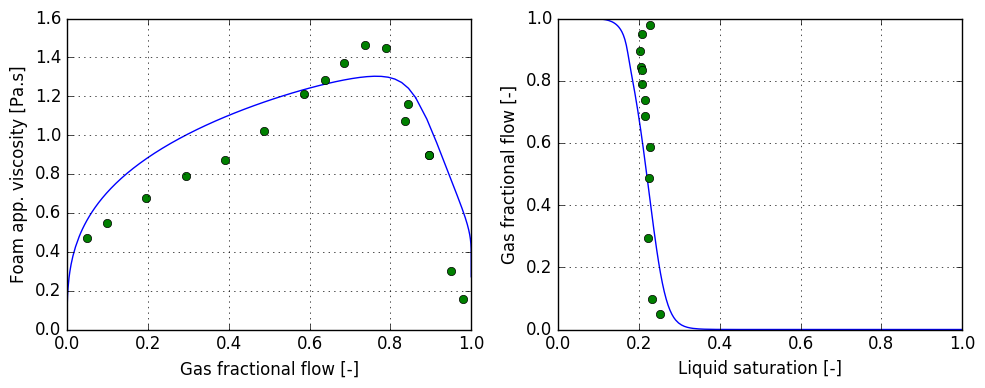

5-element Array{Float64,1}:
   7.33882e6 
 147.192     
   0.173877  
   5.03926e-5
   1.97531   

In [141]:
# m2 = Model(solver=IpoptSolver(print_level=1))
m2 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@variable(m2, 10<=fmmob<=10000000)
@variable(m2, 10<=epdry<=100000, start=80000)
@variable(m2, swc<=fmdry<=sw_exp[ind_mu_max])
# @variable(m2, fmdry==minimum(sw_ct))
@variable(m2, 1e-7<=fmcap<=1e-4)
@variable(m2, -0.0<=epcap<=4.0)
w=ones(length(muf_exp))
w[ind_mu_max-1:ind_mu_max+3]=100
w[3:4]=10
# @setNLObjective(m2, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
# @setNLObjective(m2, Min, sum{w[i]*(1.0-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)/f_foam[i]
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
# @setNLObjective(m2, :Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
# @setNLObjective(m2, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*
#    (fmcap/(u[i]*(1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*
#    (fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))/sigma_wg))^epcap)))^2, i=1:n_data})
@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
# @setNLObjective(m2, Min, sum{w[i]*(1.0-(1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))/muf_exp[i])^2, i=1:n_data})

# solve it
solve(m2)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

sw_plot = [linspace(eps(), minimum(sw_exp), 50); linspace(minimum(sw_exp)+eps()-0.00001, maximum(sw_exp), 50); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    mu_guess=mu_foam(sw_plot[i], x2[1:3])
    mu_upper=so.fminbound(fmu, 0.0, 4.0)
    if sw_plot[i]<0.198
        mu_lower=0.0
    else
        mu_lower=so.fminbound(fmu2, 1e-4, 3.0)
    end
    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
    #muf_opt[i]=fzero(fmu2, mu_guess)
end
figure(figsize=[10,4])
subplot(1,2,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave), "-")
plot(fg_exp, muf_exp, "o")
xlabel("Gas fractional flow [-]")
ylabel("Foam app. viscosity [Pa.s]")
grid()
subplot(1,2,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_ct, fg_exp, "o")
xlabel("Liquid saturation [-]")
ylabel("Gas fractional flow [-]");
grid()
tight_layout()
savefig("liquidrelperm_single_midAOS.png")

x2

# visualize all the results

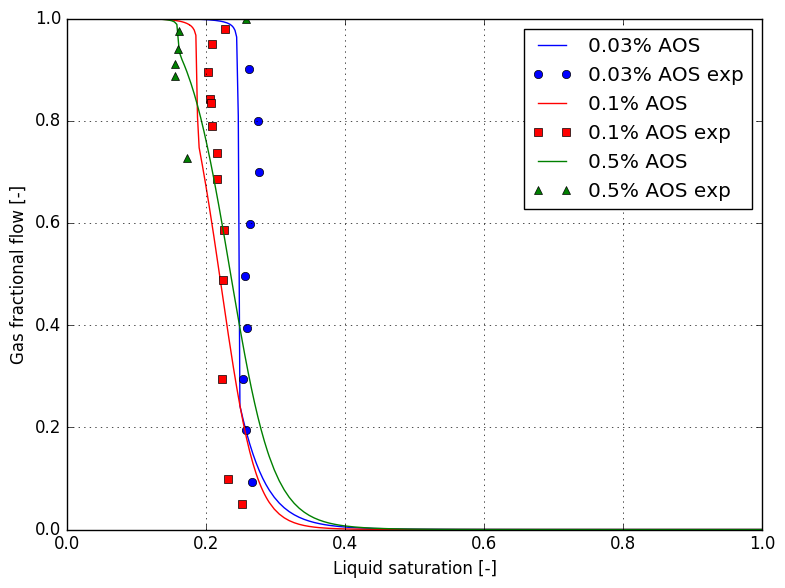

In [42]:
x=readcsv("foam_fit_single_relperm.csv") # all the fitted parameters
filenames=["AOS0.03_N2_Benth_CT_mu_foam.csv", "AOS0.1_N2_Benth_CT_mu_foam.csv", "AOS0.5_N2_Benth_CT_mu_foam.csv"]
markers=["o", "s", "^"]
colors=["b", "r", "g"]
for j=1:3
    data1=readtable(filenames[j])
    muw = float(data1[:mu_liq])
    mug = float(data1[:mu_gas])
    # Foam quality
    ug = float(data1[:ug]) # [m/s]
    uw = float(data1[:uw]) # [m/s]
    u = ug+uw # [m/s]
    fg_exp = ug./u # [-]
    # Foam apparent viscosity [Pa.s]
    muf_exp = float(data1[:muf_tot]) # [Pa.s]
    sw_ct= float(data1[:sw_ave])
    n_data = length(ug)
    # filter the low quality data for the low quality regime
    ind_mu_max= indmax(muf_exp)
    fg_trans= fg_exp[ind_mu_max]
    ind_fg_low= find(fg_exp.<=fg_trans)
    fg_low= fg_exp[ind_fg_low]
    sw_low= sw_ct[ind_fg_low]
    muf_low= muf_exp[ind_fg_low]
    muw_low= muw[ind_fg_low]
    # filter the high quality data for the high quality regime
    ind_mu_max= indmax(muf_exp)
    fg_trans= fg_exp[ind_mu_max]
    ind_fg_high= find(fg_exp.>=fg_trans)
    fg_high= fg_exp[ind_fg_high]
    sw_high= sw_ct[ind_fg_high]
    muf_high= muf_exp[ind_fg_high]
    x2=x[j+1,:]
    sw_plot = [linspace(eps(), minimum(sw_exp), 50); linspace(minimum(sw_exp)+eps()-0.00001, maximum(sw_exp), 50); 
        linspace(maximum(sw_exp)+eps(), 1.0, 100)]
    n_plot = length(sw_plot)
    muf_opt = zeros(n_plot)
    u_min = minimum(u)
    u_max = maximum(u)
    u_ave = mean(u)
    for i=1:n_plot
        #println(sw_plot[i])
        fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
        fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
        mu_guess=mu_foam(sw_plot[i], x2[1:3])
        mu_upper=so.fminbound(fmu, 0.0, 4.0)
        if sw_plot[i]<0.198
            mu_lower=0.0
        else
            mu_lower=so.fminbound(fmu2, 1e-4, 3.0)
        end
        muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
        #muf_opt[i]=fzero(fmu2, mu_guess)
    end
    plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), colors[j], 
      sw_ct, fg_exp, markers[j]*colors[j])
    
    
end
xlabel("Liquid saturation [-]")
ylabel("Gas fractional flow [-]");
legend(["0.03% AOS", "0.03% AOS exp", "0.1% AOS", "0.1% AOS exp", "0.5% AOS", "0.5% AOS exp"])
grid()
tight_layout()
savefig("frac_flow_sw_all.png")

In [64]:
x2

5-element Array{Float64,1}:
     1.54119e6
 99997.5      
     0.0885745
     1.6684e-5
     0.998781 

In [100]:
fg_opt=fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave)
muf_opt=mu_foam2(sw_plot, x2[1:3],x2[4:5], muf_opt, u_ave)
save("mid_AOS.jld", "fg", fg_opt, "muf", muf_opt, 
"sw", sw_plot, "sw_exp", sw_ct, 
"fg_exp", fg_exp, "muf_exp", muf_exp, "u", u, "cmg_stars", x2)

# Fixed fmcap

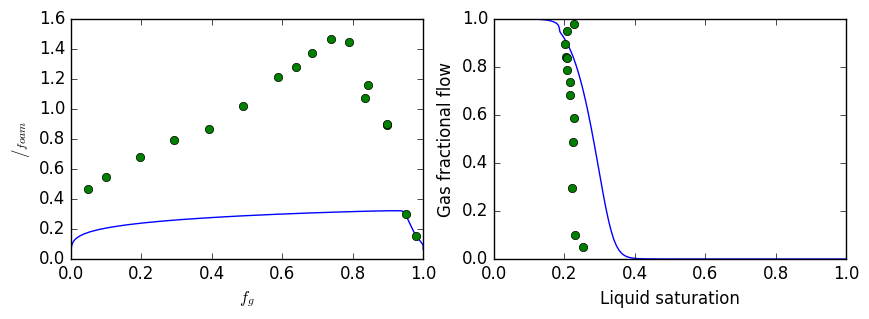

5-element Array{Float64,1}:
 96017.6     
  1381.89    
     0.186812
     8.0e-5  
     3.55557 

In [68]:
#m2 = Model(solver=IpoptSolver(print_level=1))
m2 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@defVar(m2, 10<=fmmob<=5000000)
@defVar(m2, 10<=epdry<=100000)
@defVar(m2, swc<=fmdry<=sw_exp[ind_mu_max])
@defVar(m2, fmcap==8e-5)
@defVar(m2, 0.0<=epcap<=4.0)
w=ones(length(muf_exp))
w[[3:4; ind_mu_max-2:ind_mu_max+1]]=5000
#@setNLObjective(m2, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(1.0-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)/f_foam[i]
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, :Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*
#    (fmcap/(u[i]*(1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*
#    (fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))/sigma_wg))^epcap)))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
#    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
@setNLObjective(m2, Min, sum{w[i]*(1.0-(1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))/muf_exp[i])^2, i=1:n_data})

# solve it
solve(m2)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

sw_plot = [linspace(eps(), minimum(sw_exp), 50); linspace(minimum(sw_exp)+eps()-0.00001, maximum(sw_exp), 50); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    mu_guess=mu_foam(sw_plot[i], x2[1:3])
    mu_upper=so.fminbound(fmu, 0.0, 4.0)
    if sw_plot[i]<0.198
        mu_lower=0.0
    else
        mu_lower=so.fminbound(fmu2, 1e-4, 3.0)
    end
    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
    #muf_opt[i]=fzero(fmu2, mu_guess)
end
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave), "-")
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")
subplot(1,2,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_ct, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow");
x2

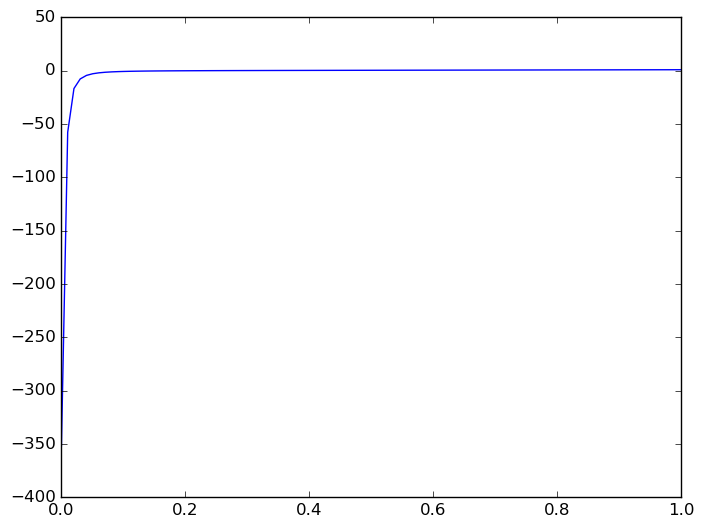

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2e04de2150>

In [72]:
mu1=linspace(0,1
,100)
fmu(x)= (x-mu_foam2(0.18892132952496024, x2[1:3], x2[4:5], x, u_ave))
fmu1=zeros(length(mu1))
for i=1:length(mu1)
    fmu1[i]=fmu(mu1[i])
end
plot(mu1,fmu1)

## Using Optim package

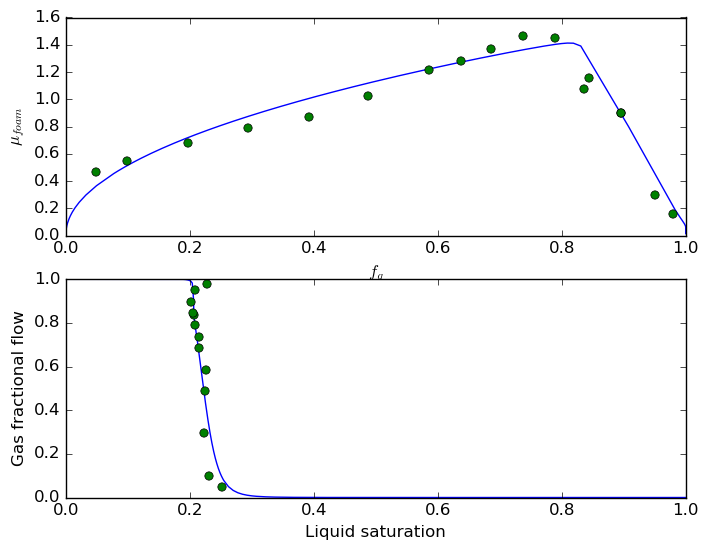

5-element Array{Float64,1}:
     1.0e6     
 10000.0       
     0.206245  
     3.54638e-5
     1.00022   

In [73]:
w[ind_mu_max-3:ind_mu_max+2]=100
f_obj(x)= sum(w.*(FM-1.0./(1.0+x[1]*(0.5+atan(x[2]*(sw_exp-x[3]))/pi).*(x[4]./(u.*muf_exp/sigma_wg)).^x[5])).^2)
x_low=[10.0, 10.0, swc, 1e-7, -4.0]
x_high=[5.0e6, 1.0e6, 0.4, 1.0e-4, 4.0]
d4 = DifferentiableFunction(f_obj)
opt_out=fminbox(d4, [1.0e6, 1.0e4, swc+0.02, 1e-5, 1.0], x_low, x_high)
x2=opt_out.minimum
sw_plot = [linspace(eps(), minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    mu_upper=so.fminbound(fmu, 0.0, 5.0)
    mu_lower=so.fminbound(fmu2, 0.0, 5.0)
    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
end
subplot(2,1,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave))
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")
subplot(2,1,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_ct, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow");
x2

# 5. A discontinuous model

Note: $f_g$ --> 0, $\mu_{app}$ --> $\mu_{app,0}$  
The first step is to fit a curve (line, polynomial, or power law) to the low quality regime and find the $\mu_{app,0}$. Then, the new functions that are defined below will be used to fit the foam scan data.

In [74]:
# define the new model with mu_app0
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2, mu0)=mu0+(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u, mu0)=mu0+(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 2 methods)

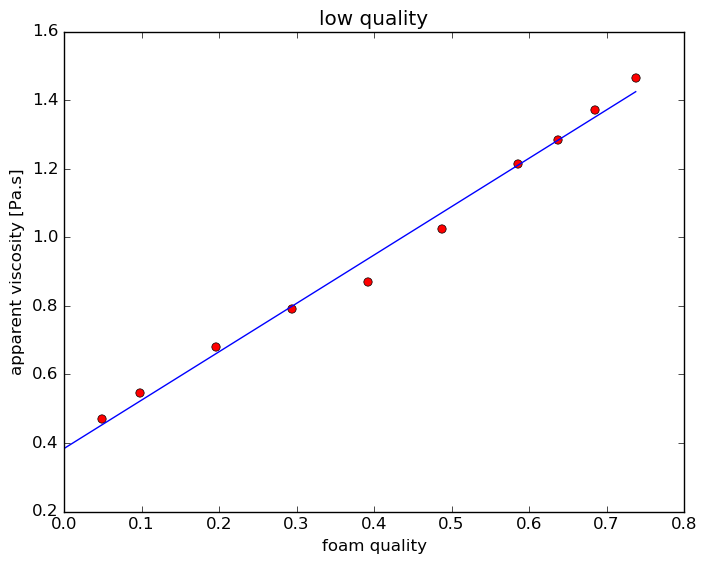

PyObject <matplotlib.text.Text object at 0x7f2e01ef3f50>

In [75]:
(muf_0,dmudfg)=linreg(fg_low, muf_low)
fg_low_range=linspace(0.0, maximum(fg_low), 20)
plot(fg_low, muf_low, "or", fg_low_range, dmudfg*fg_low_range+muf_0)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
title("low quality")

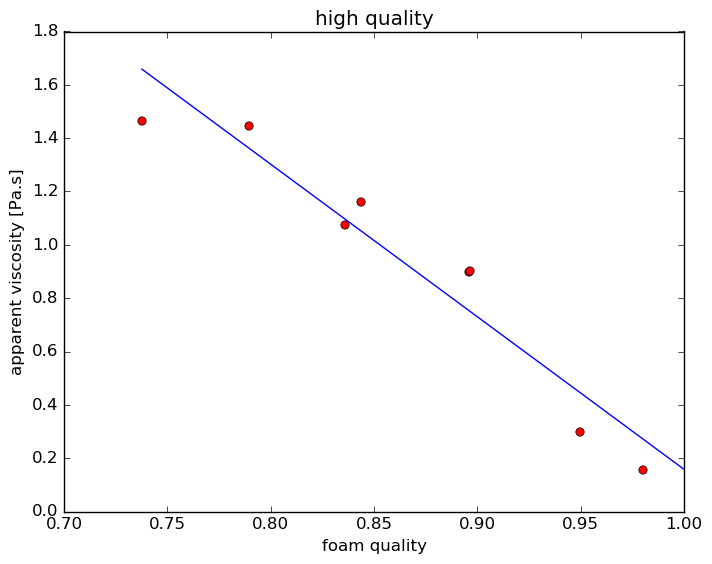

0.1582381434817286

In [76]:
(muf_end,dmudfg)=linreg(fg_high, muf_high)
fg_high_range=linspace(minimum(fg_high), 1.0, 20)
plot(fg_high, muf_high, "or", fg_high_range, dmudfg*fg_high_range+muf_end)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
title("high quality")
[dmudfg*fg_high_range+muf_end][end]

A negative value is obtained. The fit is not really a fit. I would say at fg=0, we can go with the gas viscosity.

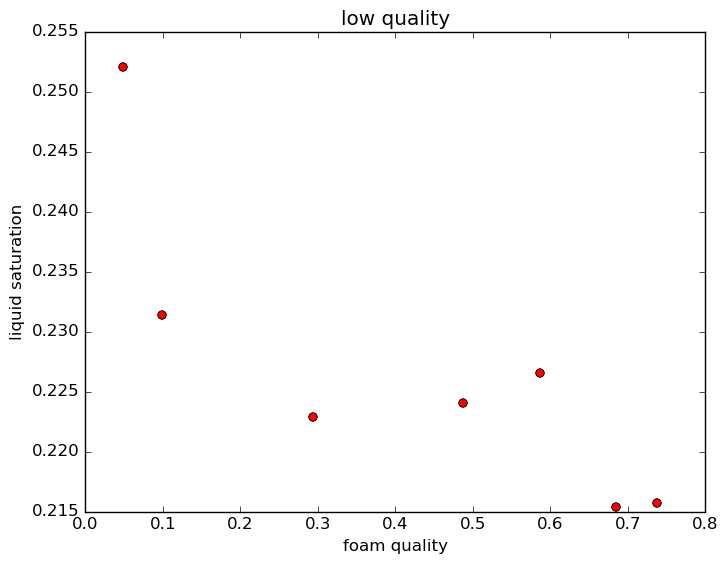

NaN

In [77]:
plot(fg_low, sw_low, "or")
(sw_0,dswdfg)=linreg(fg_low, sw_low)
plot(fg_low, sw_low, "or", fg_low_range, dswdfg*fg_low_range+sw_0)
xlabel("foam quality")
ylabel("liquid saturation")
title("low quality")
sw_0

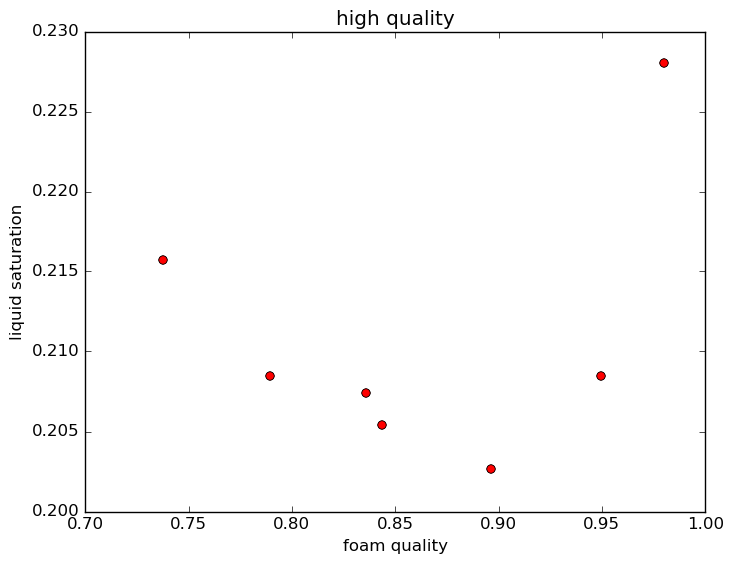

NaN

In [78]:
plot(fg_high, sw_high, "or")
(sw_end,dswdfg)=linreg(fg_high, sw_high)
plot(fg_high, sw_high, "or", fg_high_range, dswdfg*fg_high_range+sw_end)
xlabel("foam quality")
ylabel("liquid saturation")
title("high quality")
[dswdfg*fg_high_range+sw_end][end]